In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from fbprophet import Prophet
import altair as alt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import os
import datetime

Importing plotly failed. Interactive plots will not work.


In [2]:
fpath = '/home/cdsw/data'
f = 'cash_flow_202102191035.csv'


cashflow = pd.read_csv(os.path.join(fpath, f))
cashflow.head()

date inflow_outflow     cash_flow_type unit_responsible       amount  \
0  2018-01-02    cash_inflow         Collection             LMCD         0.00   
1  2018-01-02    cash_inflow     Deposits-Banks        FSD/ACCTG  36514685.00   
2  2018-01-02    cash_inflow  Deposits-LandBank        FSD/ACCTG    325728.33   
3  2018-01-02   cash_outflow  Opex and Payments       Accounting    267627.80   
4  2018-01-02   cash_outflow        Withdrawals       Accounting  14747080.85   

      net_loan  
0  21825704.68  
1  21825704.68  
2  21825704.68  
3  21825704.68  
4  21825704.68

### Data Pre-Process

In [3]:
def pre_process(cashflow):
    cashflow['date'] = pd.to_datetime(cashflow['date'])
    new_cashflow = cashflow[['date', 'cashflow']]
    new_cashflow.columns = ['date', 'cashflow']
    new_cashflow = new_cashflow.drop_duplicates(keep='first')
    
    return new_cashflow

In [4]:
cashflow.dtypes

date                 object
inflow_outflow       object
cash_flow_type       object
unit_responsible     object
amount              float64
net_loan            float64
dtype: object

In [5]:
cashflow['date'] = pd.to_datetime(cashflow['date'])
cashflow.dtypes

date                datetime64[ns]
inflow_outflow              object
cash_flow_type              object
unit_responsible            object
amount                     float64
net_loan                   float64
dtype: object

In [6]:
cashflow = cashflow.drop_duplicates(subset=['date' , 'net_loan'], keep='first')
cashflow['year'] = cashflow['date'].dt.year
cashflow['month'] = cashflow['date'].dt.month
cashflow = cashflow[['date', 'net_loan', 'year', 'month']]
cashflow.columns = ['date', 'cashflow', 'year', 'month']
cashflow.head()

date     cashflow  year  month
0  2018-01-02  21825704.68  2018      1
5  2018-01-03  86854969.69  2018      1
10 2018-01-04  68215630.91  2018      1
15 2018-01-07   2524747.10  2018      1
20 2018-01-08 -32169321.51  2018      1

In [7]:
# used for training

new_cashflow = cashflow.copy()
new_cashflow = new_cashflow[new_cashflow['year'] != 2020]
new_cashflow.year.value_counts()

2019    249
2018    240
2021     20
Name: year, dtype: int64

### Model Training

In [8]:
def train_model(data, holidays=False, ws=False, ys=False, ds=False, ms=False, iw=0.85):
    ts = data
    ts.columns = ['ds', 'y']
    if isinstance(holidays, pd.DataFrame):
        model = Prophet(weekly_seasonality=ws, yearly_seasonality=ys, daily_seasonality=ds, interval_width=iw, holidays=holidays)
    else:
        model = Prophet(weekly_seasonality=ws, yearly_seasonality=ys, daily_seasonality=ds, interval_width=iw)
    if ms:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model = model.fit(ts)
    return model

def predict(model, n):
    forecast = model.make_future_dataframe(periods=n, freq='D')
    predictions = model.predict(forecast)
    figure = model.plot(predictions)
    plt.title('Cash Flow Projection', fontsize=25)
    return predictions

def custom_predict(model, data):
    data = data[['date']]
    data.columns = ['ds']
    predictions = model.predict(data)
    return predictions

def evaluate(y_true, yhat):
    rmse = np.sqrt(mean_squared_error(y_true, yhat))
    r2 = r2_score(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    metrics = [{
        'Root Mean Squared Error' : rmse,
        'R-squared' : r2,
        'Mean Absolute Error' : mae,
    }]
    performance = pd.DataFrame(metrics)
    return performance

def create_holidays(start_year, end_year):
    holiday_df = []
    holidays = [("New Year's Day", '-01-01'), ("Maundy Thursday", '-04-01'), ("Good Friday", '-04-02'), 
            ("Araw ng Kagitingan", '-04-09'), ("Labor Day", '-05-01'), ("Independence Day", '-06-12'), 
            ("National Heroes’ Day", '-08-30'), ("Bonifacio Day", '-11-30'), ("Christmas Day", '-12-25'),
            ("Rizal Day", '-12-30')]
            
    for year in range(start_year, end_year+1, 1):
        for h in holidays:
            holiday_df.append({
              'ds':str(year)+h[1],
              'holiday':h[0],
              'lower_window': 0,
              'upper_window': 0,
            })

    holiday_df = pd.DataFrame(holiday_df)
    holiday_df['ds'] = pd.to_datetime(holiday_df.ds)
    return holiday_df

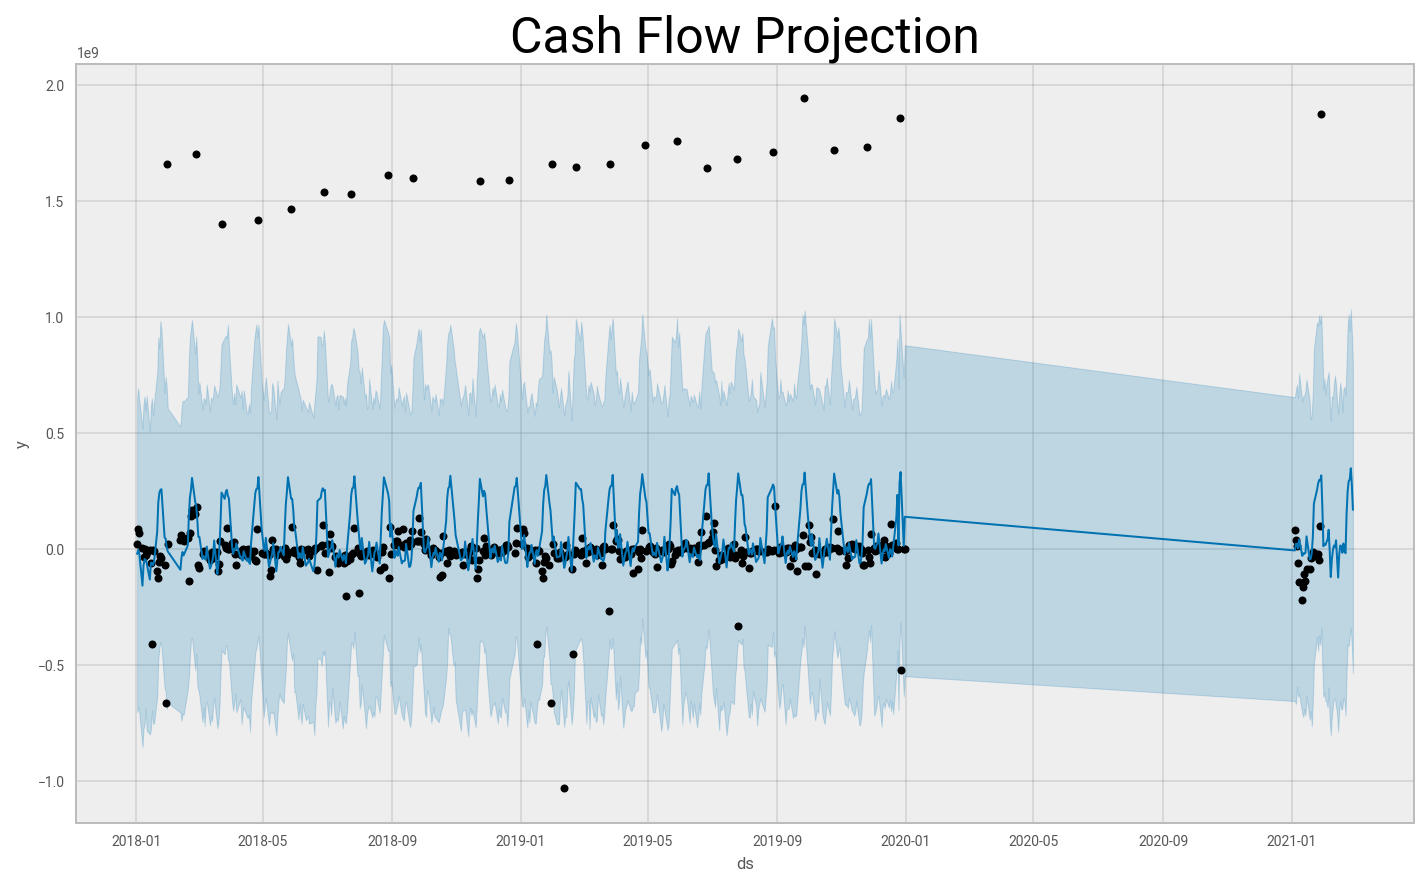

In [9]:
holidays = create_holidays(2018, 2022)
model = train_model(new_cashflow[['date', 'cashflow']], ws=True, ms=True, iw=0.95, holidays=holidays)
predictions = predict(model, 30)

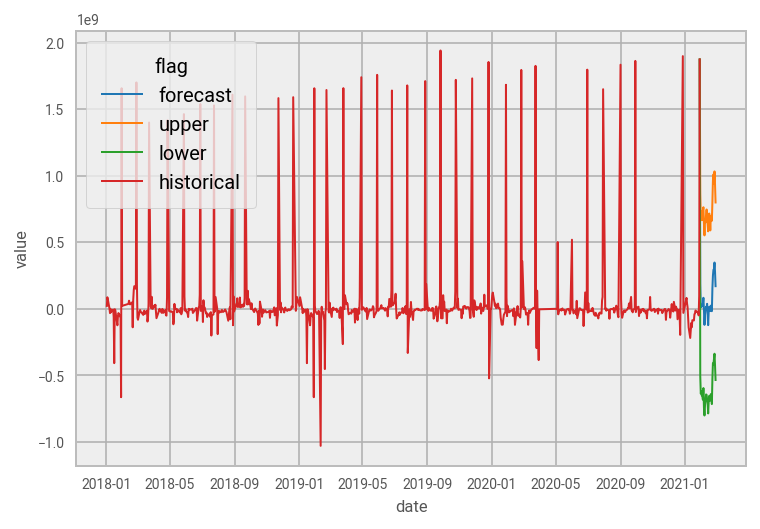

In [10]:
result = predictions.reset_index()
standard_cols = ['date', 'value', 'flag']
historical = cashflow.copy()

historical = historical[['date', 'cashflow']]
historical['flag'] = 'historical'

forecast = result[-30:][['ds', 'yhat']]
forecast['flag'] = 'forecast'

upper = result[-30:][['ds', 'yhat_upper']]
upper['flag'] = 'upper'

lower = result[-30:][['ds', 'yhat_lower']]
lower['flag'] = 'lower'

historical.columns = standard_cols
forecast.columns = standard_cols
upper.columns = standard_cols
lower.columns = standard_cols

new_forecast = forecast.append(historical[-1:])
new_forecast['flag'] = new_forecast['flag'].replace(['historical', 'forecast'])

new_upper = upper.append(historical[-1:])
new_upper['flag'] = new_upper['flag'].replace(['historical', 'upper'])

new_lower = lower.append(historical[-1:])
new_lower['flag'] = new_lower['flag'].replace(['historical', 'lower'])

power_bi = pd.concat([new_forecast, new_upper, new_lower, historical], axis=0)
sns.lineplot(data=power_bi, x='date', y='value', hue='flag')

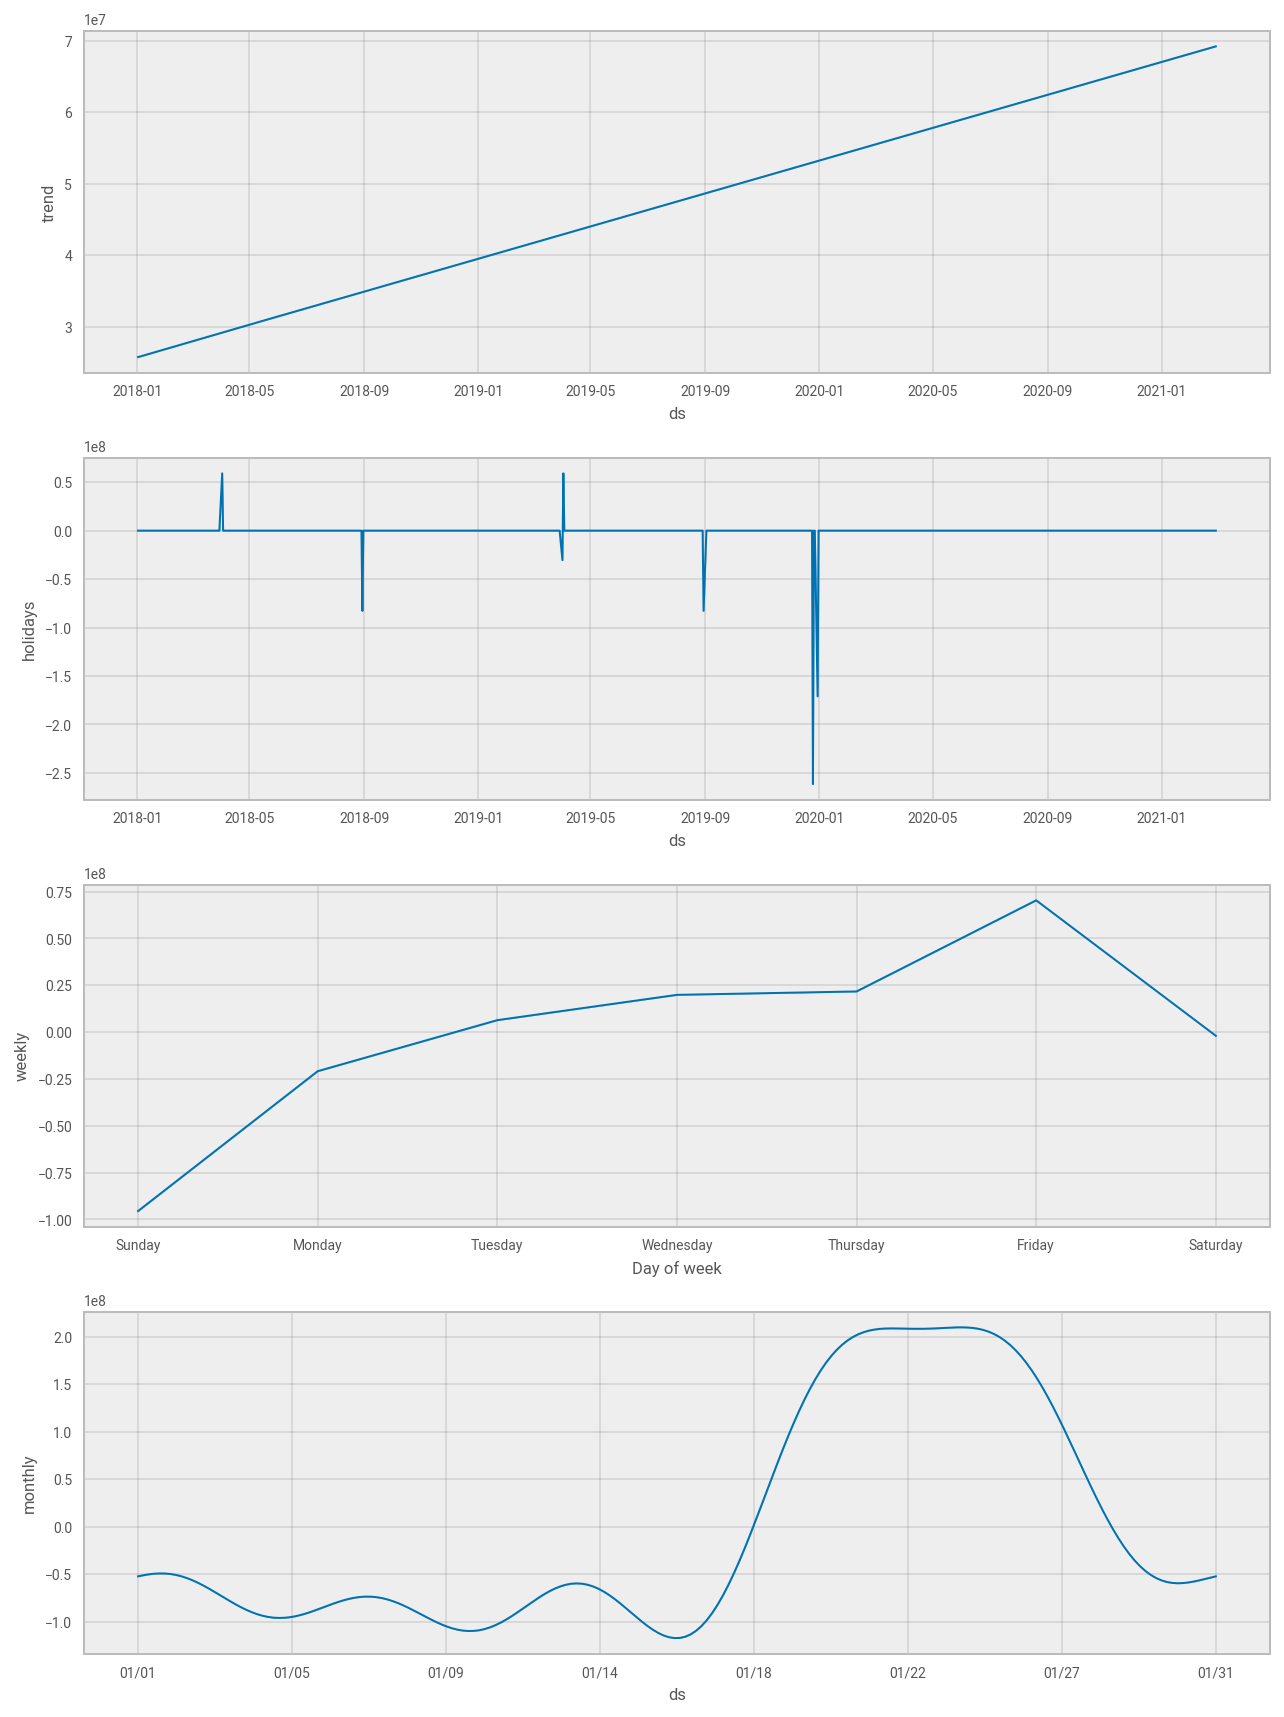

In [11]:
fig = model.plot_components(predictions.reset_index())

### Model Perfromance

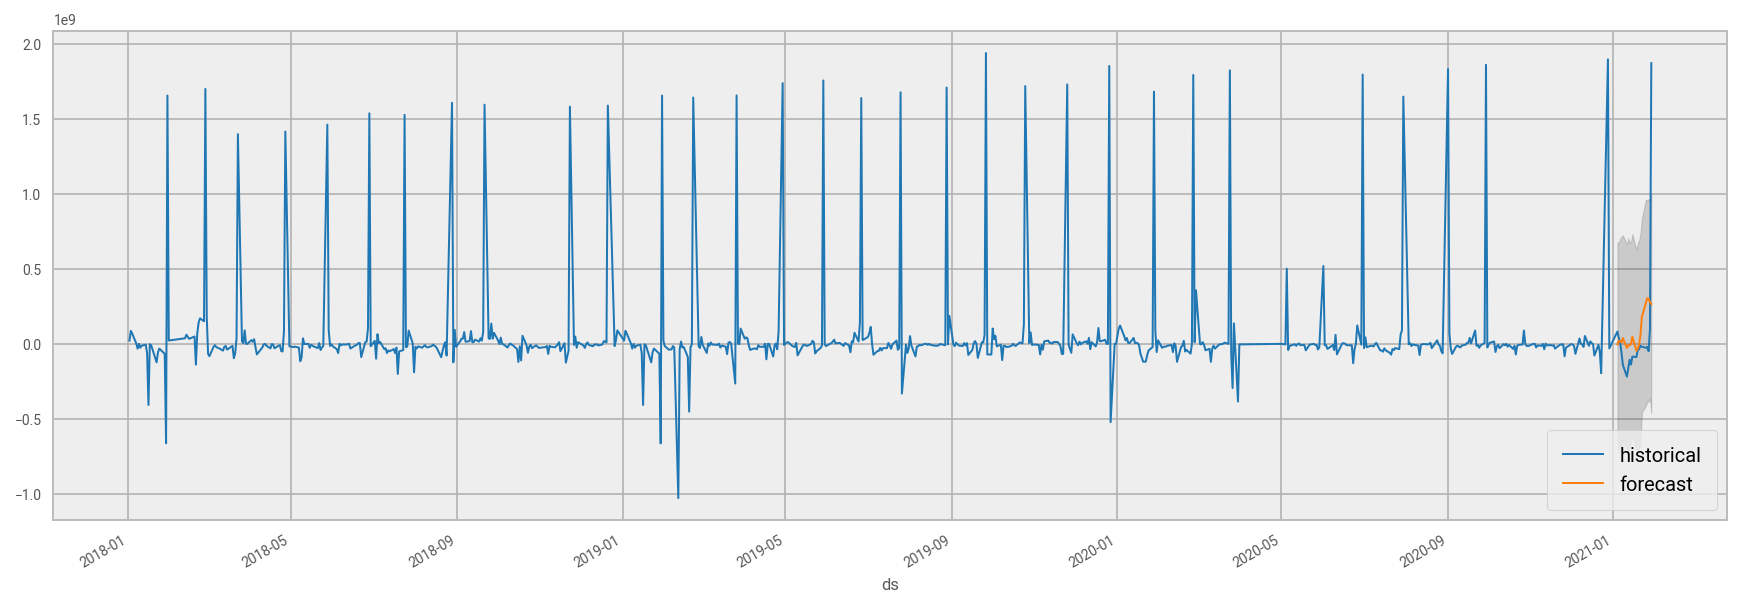

In [12]:
train_set = new_cashflow[new_cashflow['year'] != 2021]
test_set = new_cashflow[new_cashflow['year'] == 2021]
historical = cashflow.copy()

model = train_model(train_set[['date', 'cashflow']], ws=True, ms=True, iw=0.95)
predictions = custom_predict(model, test_set)
historical = historical.set_index('date')
historical['cashflow'].plot(legend=True, label='historical', figsize=(15,5))
predictions = predictions.set_index('ds')
predictions['yhat'].plot(legend=True, label='forecast')
plt.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=.15)
plt.show()

In [13]:
eval_perf = predictions[['yhat']].reset_index()
eval_perf = eval_perf.merge(test_set, left_on='ds', right_on='date', how='left').drop(['date', 'year', 'month'], axis=1)
eval_perf.columns = ['date', 'yhat', 'y']
evaluate(eval_perf['y'], eval_perf['yhat'])

Root Mean Squared Error  R-squared  Mean Absolute Error
0             3.957758e+08   0.138932         2.090351e+08